# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Train/Test Split](#4.5_Train/Test_Split)
  * [4.6 Scaling data](#4.6_Scaling_data)
  * [4.7 Initial Models](#4.7_Initial_Models)
  * [4.8 Models Perfomance](#4.8_Models_Perfomance)
  * [4.9 Final Model Selection](#4.9_Final_Model_Selection)    
  * [4.10 Data quantity assessment](#4.10_Data_quantity_assessment)
  * [4.11 Save best model object](#4.11_Save_best_model_object)
  


## 4.2 Introduction<a id='4.2_Introduction'></a>

In preceding notebooks, performed preliminary assessments of data quality and refined the question to be answered. The detecting the normal ecgs was the primary aim. 

In this notebook we'll start to build machine learning models. The first model is a baseline performance comparitor for any subsequent model. Then, models are built and the process of efficiently and robustly creating and assessing models against it will be performed. 

## 4.3 Imports<a id='4.3_Imports'></a>

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC

from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel

import datetime

from library.sb_utils import save_file

## 4.4 Load Data<a id='4.4_Load_Data'></a>

In [3]:
ecg_data = pd.read_csv('../data/ecg_data_step3_features.csv')
# ecg_data = pd.read_csv('../data/ecg_data_step3_features_uncorrelated85.csv')

ecg_data.head().T

,0,1,2,3,4
t0,-0.112522,-1.100878,-0.567088,0.490473,0.800232
t1,-2.827204,-3.996840,-2.593450,-1.914407,-0.874252
t2,-3.773897,-4.285843,-3.874230,-3.616364,-2.384761
t3,-4.349751,-4.506579,-4.584095,-4.318823,-3.973292
t4,-4.376041,-4.022377,-4.187449,-4.268016,-4.338224
...,...,...,...,...,...
t136,0.228077,0.476333,-0.532197,0.990133,0.960304
t137,0.123431,0.773820,0.321097,1.086798,0.971020
t138,0.925286,1.119621,0.904227,1.403011,1.614392
t139,0.193137,-1.436250,-0.421797,-0.383564,1.421456


In [4]:
# ecg_data.Target = ['ABNORMAL' if x == 0.0 else 'NORMAL' for x in ecg_data.Target] 
# ecg_data = ecg_data[['t0','t1','t6','t7','t139', 'Target']]
ecg_data.Target = ecg_data.Target.astype('int')
ecg_data.head().T

,0,1,2,3,4
t0,-0.112522,-1.100878,-0.567088,0.490473,0.800232
t1,-2.827204,-3.996840,-2.593450,-1.914407,-0.874252
t2,-3.773897,-4.285843,-3.874230,-3.616364,-2.384761
t3,-4.349751,-4.506579,-4.584095,-4.318823,-3.973292
t4,-4.376041,-4.022377,-4.187449,-4.268016,-4.338224
...,...,...,...,...,...
t136,0.228077,0.476333,-0.532197,0.990133,0.960304
t137,0.123431,0.773820,0.321097,1.086798,0.971020
t138,0.925286,1.119621,0.904227,1.403011,1.614392
t139,0.193137,-1.436250,-0.421797,-0.383564,1.421456


## 4.5 Train/Test Split<a id='4.5_Train/Test_Split'></a>

In [5]:
# check if the dataset is balanced
ecg_data.Target.value_counts(normalize=True)

1    0.633425
0    0.366575
Name: Target, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(ecg_data.drop(columns='Target'), 
                                                    ecg_data.Target, test_size=0.2,
                                                    stratify= ecg_data.Target,random_state=47)

# X_train, X_val, y_train, y_val = train_test_split(X_train, 
#                                                     y_train, test_size=0.2,
#                                                     stratify= y_train,random_state=47)


# X_train, X_test, y_train, y_test 
#     = train_test_split(X, y, test_size=0.2, random_state=1)

#  X_train, X_val, y_train, y_val 
#     = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [7]:
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((2623, 140), (2623,), (656, 140), (656,))

## 4.6 Scaling data<a id='4.6_Scaling_data'></a>

In [8]:
# https://towardsdatascience.com/data-leakage-in-machine-learning-6161c167e8ba
# https://stats.stackexchange.com/questions/569024/when-we-use-standardscaler-in-pipeline-with-gridsearchcv-does-it-automaticall

def scale_data(Scaler,X_train, X_test):
    sc = Scaler
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test

# X_train, X_test = scale_data(StandardScaler(),X_train, X_test )

## 4.7 Models<a id='4.7_Models'></a>

In [9]:
# Show model's performance

def model_results(model, y_train, y_tr_pred, y_test, y_te_pred, show_training_result=True ):

    print( model)
    print('-------------------------------------')
    # print(f'Accuracy on training data: {accuracy_score(y_tr_pred, y_train):.2f}')
    # print(f'Accuracy on test data: {accuracy_score(y_te_pred, y_test):.2f}')
    # print('-------------------------------------')
    # print(f'Precision score on training data: {precision_score(y_train, y_tr_pred):.2f}')
    # print(f'Precision score  on test data: {precision_score( y_test, y_te_pred):.2f}')
    # print('-------------------------------------')
    # print(f'Recall score on training data: {recall_score(y_train, y_tr_pred):.2f}')
    # print(f'Recall score  on test data: {recall_score( y_test, y_te_pred):.2f}')
    # print('-------------------------------------')
    # print(f'F1 score on training data: {f1_score(y_train, y_tr_pred):.2f}')
    # print(f'F1 score  on test data: {f1_score( y_test, y_te_pred):.2f}')
    # print('-------------------------------------')
    if show_training_result:
        print("Classification Report for Training Data")
        print(classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']))
    print('-------------------------------------')
    print("Classification Report for Test Data")
    print(classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']))


In [10]:
# Plot Model's ROC

def plot_ROC(model,X, y, title_method ):
    
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='{} (area = {:2.2%})'.format(title_method,logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [11]:
#  train and test a model 

def train_test_model(model, grid_params, X_train, y_train, X_test, y_test, model_name):
    pipe = make_pipeline(
    StandardScaler(),
    model
    )

    rskf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle=False)
    model_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=rskf, n_jobs=-1)
    # print(model_grid_cv.get_params().keys())
    # print(model_grid_cv)
    model_grid_cv.fit(X_train, y_train)
    
    y_tr_pred = model_grid_cv.predict(X_train)
    y_te_pred = model_grid_cv.predict(X_test)
    


    if model_name in ['Random Forest', 'K_Neighbors'] :
        show_training_result = False
    else:
        show_training_result= True
    model_results(model_name, y_train, y_tr_pred, y_test, y_te_pred,show_training_result )  
    plot_ROC(model_grid_cv, X_test, y_test, model_name)

    row_model = {'model_name':model_name, 'Accuracy on training data':accuracy_score(y_tr_pred, y_train), 'Accuracy on test data':accuracy_score(y_te_pred, y_test),
'Precision score on training data':precision_score(y_train, y_tr_pred), 'Precision score  on test data':precision_score( y_test, y_te_pred), 
'Recall score on training data':recall_score(y_train, y_tr_pred), 'Recall score  on test data':recall_score( y_test, y_te_pred), 
'F1 score on training data':f1_score(y_train, y_tr_pred), 'F1 score  on test data':f1_score( y_test, y_te_pred), 
'Classification Report for Training Data':classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']), 
'Classification Report for Test Data':classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']), 
'best_params_':model_grid_cv.best_params_

    }
    return(row_model) 



In [ ]:
# https://www.programcreek.com/python/?code=dssg%2Fdiogenes%2Fdiogenes-master%2Ftests%2Ftest_grid_search.py#
# http://dssg-diogenes.github.io/diogenes/doc/_build/html/user_guide/grid_search.html
import diogenes.grid_search as per
import diogenes.display as dsp

def test_slice_on_dimension(self):
        
        y = ecg_data.Target
        M = ecg_data
        clfs = [{'clf': RandomForestClassifier, 
                 'n_estimators': [10, 100], 
                 'max_depth': [1, 10],
                 'random_state': [0]}
                 ]        
        subsets = [{'subset': per.SubsetRandomRowsActualDistribution, 
                    'subset_size': [20, 40, 60, 80, 100],
                    'random_state': [0]}]
        cvs = [{'cv': StratifiedKFold}]
        exp = per.Experiment(M, y, clfs, subsets, cvs)
        result = [str(trial) for trial in exp.slice_on_dimension(
                per.CLF, 
                RandomForestClassifier).trials]
        self.__compare_to_ref_pkl(result, 'slice_on_dimension_clf')
        result = [str(trial) for trial  in exp.slice_on_dimension(
                per.SUBSET_PARAMS, 
                {'subset_size': 60}).trials]
        self.__compare_to_ref_pkl(result, 'slice_on_dimension_subset_params') 

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Logistic Regression
-------------------------------------
Classification Report for Training Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      1.00      1.00       962
      NORMAL       1.00      1.00      1.00      1661

    accuracy                           1.00      2623
   macro avg       1.00      1.00      1.00      2623
weighted avg       1.00      1.00      1.00      2623

-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.99      0.99       240
      NORMAL       0.99      1.00      1.00       416

    accuracy                           1.00       656
   macro avg       1.00      0.99      1.00       656
weighted avg       1.00      1.00      1.00       656



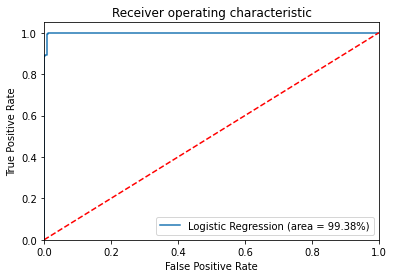

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Random Forest
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.99      0.99       240
      NORMAL       0.99      1.00      1.00       416

    accuracy                           1.00       656
   macro avg       1.00      0.99      1.00       656
weighted avg       1.00      1.00      1.00       656



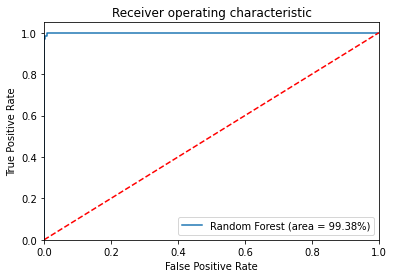

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K_Neighbors
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.99      0.99       240
      NORMAL       0.99      1.00      1.00       416

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



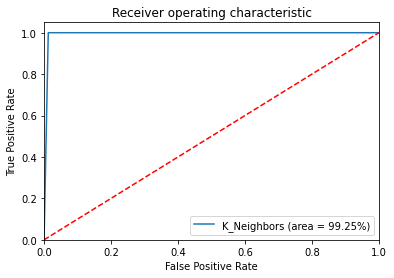

In [12]:
# define 3 models LogisticRegression, RandomForestClassifier, and KNeighborsClassifier and their parameters
params = [
    {'classifier' : [LogisticRegression(random_state=42)], 'model_name' : ['Logistic Regression'],
    'param_grid': { 'logisticregression__penalty' : ['l1', 'l2', None], 'logisticregression__C' : np.logspace(-3,3,7), 'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear']}},
    {'classifier' : [RandomForestClassifier(random_state=42)], 'model_name' : ['Random Forest'],
    'param_grid': { 'randomforestclassifier__n_estimators' : list(range(10,100,200)), 'randomforestclassifier__max_depth' : [4,5,6,7,8], 'randomforestclassifier__criterion' :['gini', 'entropy']}}, 
    {'classifier' : [KNeighborsClassifier()], 'model_name' : ['K_Neighbors'],
    'param_grid': { 'kneighborsclassifier__weights': ['uniform','distance'],'kneighborsclassifier__n_neighbors': [2]}}
]


# define a dataframe to save performance metrics
df_results = pd.DataFrame(columns=['model_name', 'Accuracy on training data', 'Accuracy on training data',
'Precision score on training data', 'Precision score  on test data', 
'Recall score on training data', 'Recall score  on test data', 
'F1 score on training data', 'F1 score  on test data', 
'Classification Report for Training Data', 
'Classification Report for Test Data', 
'best_params_'])

# train and test models
for model_params in params:
    model = model_params['classifier'][0]
    param_grid = model_params['param_grid']
    model_name = model_params['model_name'][0]
    result = train_test_model(model, param_grid, X_train, y_train, X_test, y_test, model_name)
    
    df_results.loc[len(df_results.index)] = result


In [66]:
df_results

,model_name,Accuracy on training data,Accuracy on training data,Precision score on training data,Precision score on test data,Recall score on training data,Recall score on test data,F1 score on training data,F1 score on test data,Classification Report for Training Data,Classification Report for Test Data,best_params_
0,Logistic Regression,0.922139,0.922139,0.926277,0.942308,0.941649,0.944325,0.933900,0.943316,precision recall f1-score ...,precision recall f1-score ...,"{'logisticregression__C': 10.0, 'logisticregre..."
1,Random Forest,0.978424,0.978424,0.977188,0.965443,0.986081,0.957173,0.981615,0.961290,precision recall f1-score ...,precision recall f1-score ...,{'randomforestclassifier__criterion': 'entropy...
2,K_Neighbors,1.000000,1.000000,1.000000,0.959227,1.000000,0.957173,1.000000,0.958199,precision recall f1-score ...,precision recall f1-score ...,"{'kneighborsclassifier__n_neighbors': 2, 'knei..."


## 4.9 Final Model Selection<a id='4.9_Final_Model_Selection'></a>

## 4.10 Data quantity assessment<a id='4.10_Data_quantity_assessment'></a>

Finally, you need to advise the business whether it needs to undertake further data collection. Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

In [67]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

NameError: name 'pipe' is not defined

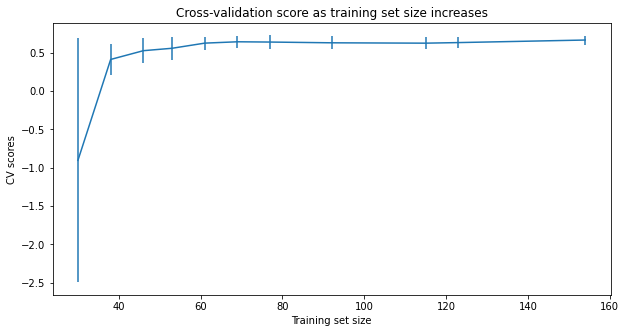

In [ ]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 40-50.

## 4.11 Save best model object<a id='4.10_Save_best_model_object'></a>

In [ ]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [ ]:
# save the model

modelpath = '../models'
save_file(best_model, 'ECG_model.pkl', modelpath)

Directory ../models was created.
Writing file.  "../models\ski_resort_pricing_model.pkl"
